In [2]:
import sys
# setting path
sys.path.append('..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from src import io, var, utils, fourier, lin_reg, reconstruction, physics
from vis import plotter

import importlib
importlib.reload(io)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)
importlib.reload(physics)

importlib.reload(plotter)

<module 'vis.plotter' from '/home/ray/git-projects/spec_appx/notebooks/../vis/plotter.py'>

Setup objects and read data. Specify the extent of the lat-lon grid to be read in.

In [4]:
# initialise data objects
grid = var.grid()
topo = var.topo_cell()

# read grid
reader = io.ncdata()
fn = '../data/icon_compact.nc'
reader.read_dat(fn, grid)
grid.apply_f(utils.rad2deg)

# read topography
fn = '../data/topo_compact.nc'
reader.read_dat(fn, topo)

# we only keep the topography that is inside this lat-lon extent.
lat_verts = np.array([52.,64.,64.])
lon_verts = np.array([-141.,-158.,-127.])

reader.read_topo(topo, topo, lon_verts, lat_verts)

Data fetched...


Plot the loaded topography...

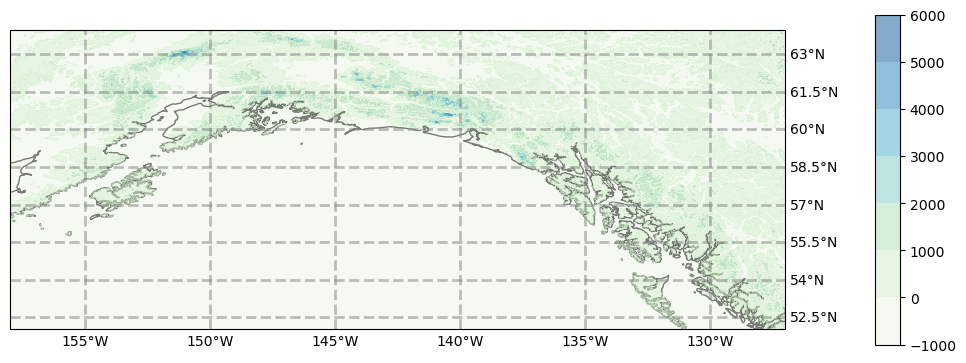

In [5]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

topo.gen_mgrids()

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
im = ax.contourf(topo.lon_grid, topo.lat_grid, topo.topo,
            alpha=0.5,
            transform=ccrs.PlateCarree(),
            cmap='GnBu',
            # vmin=0.0,
            # vmax=3000.0
            )

cax = fig.add_axes([0.99, 0.22, 0.025, 0.55])
fig.colorbar(im, cax=cax)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False

gl.xlocator = LongitudeLocator()
gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter(auto_hide=False)
gl.yformatter = LatitudeFormatter()

ax.tick_params(axis="both",
               tickdir='out',
               length=15,
               grid_transform=ccrs.PlateCarree())

plt.show()

Setup Delaunay triangulation domain.

In [6]:
from scipy.spatial import Delaunay
import matplotlib.tri as tri

# Partition lat-lon domain into a number of coarser but regularly spaces points that will form the vertices of the Delaunay triangles.
xlen = len(topo.lon)
ylen = len(topo.lat)
xPoints = np.linspace(0,xlen-1,11)
yPoints = np.linspace(0,ylen-1,6)

YY,XX = np.meshgrid(yPoints,xPoints)

# Now we get the points by index.
points = np.array([list(item) for item in zip(XX.ravel(), YY.ravel())]).astype('int')

lat_verts = topo.lat_grid[points[:,1], points[:,0]]
lon_verts = topo.lon_grid[points[:,1], points[:,0]]

# Using these indices, we get the list of points in (lon,lat).
points = np.array([list(item) for item in zip(lon_verts, lat_verts)])

lats = points[:,1]
lons = points[:,0]

# Using scipy spatial, we setup the Delaunay decomposition
tri = Delaunay(points)

# Convert the vertices of the simplices to lat-lon values.
tri_lat_verts = lats[tri.simplices]
tri_lon_verts = lons[tri.simplices]

print("number of triangles =", len(tri_lat_verts))

# Compute the centroid for each vertex.
tri_clats = tri_lat_verts.sum(axis=1) / 3.0
tri_clons = tri_lon_verts.sum(axis=1) / 3.0

number of triangles = 100


Plot the Delaunay triangular, its vertices, and the computed centroids against the background of the topography.

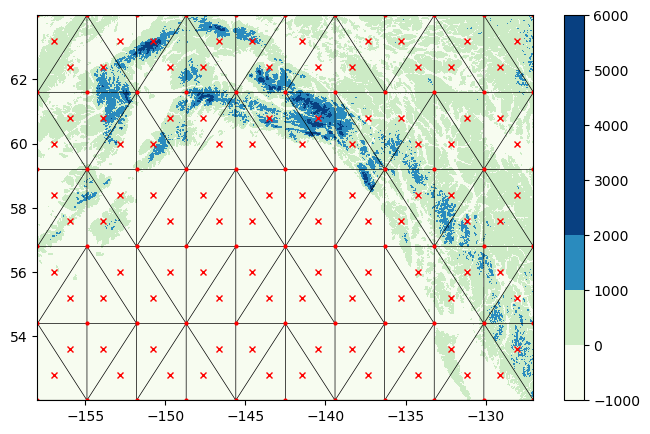

In [7]:
plt.figure(figsize=(8,5))
plt.contourf(topo.lon_grid, topo.lat_grid, topo.topo, vmin=0.0, vmax=2000.0, cmap='GnBu')
plt.triplot(points[:,0], points[:,1], tri.simplices, c='k', lw=0.5)
plt.plot(points[:,0], points[:,1], 'ro', ms=2.0)
plt.plot(tri_clons, tri_clats, 'rx', ms=4.0)
plt.colorbar()
plt.show()

Define function that computes whether a point is in a polygon, and rescales the lat-lon grid to a local coordinate between [0,1].

Taken from: https://github.com/sasamil/PointInPolygon_Py/blob/master/pointInside.py

In [8]:
import numba as nb

def mask_wrapper(polygon):
    return lambda p : is_inside_sm(p, polygon)

@nb.njit
def is_inside_sm(point, polygon):
    length = len(polygon)-1
    dy2 = point[1] - polygon[0][1]
    intersections = 0
    ii = 0
    jj = 1

    while ii<length:
        dy  = dy2
        dy2 = point[1] - polygon[jj][1]

        # consider only lines which are not completely above/bellow/right from the point
        if dy*dy2 <= 0.0 and (point[0] >= polygon[ii][0] or point[0] >= polygon[jj][0]):

            # non-horizontal line
            if dy<0 or dy2<0:
                F = dy*(polygon[jj][0] - polygon[ii][0])/(dy-dy2) + polygon[ii][0]

                if point[0] > F: # if line is left from the point - the ray moving towards left, will intersect it
                    intersections += 1
                elif point[0] == F: # point on line
                    return 1

            # point on upper peak (dy2=dx2=0) or horizontal line (dy=dy2=0 and dx*dx2<=0)
            elif dy2==0 and (point[0]==polygon[jj][0] or (dy==0 and (point[0]-polygon[ii][0])*(point[0]-polygon[jj][0])<=0)):
                return 1

        ii = jj
        jj += 1

    #print 'intersections =', intersections
    return intersections & 1  

def rescale(arr):
    arr -= arr.min()
    arr /= arr.max()
    
    return arr

Prepare Delaunay simplices for the looping...

In [9]:
# Make circular vertex points, e.g. the last point is also the first point:
circ_tri_lat_verts = np.hstack((tri_lat_verts,tri_lat_verts[:,0].reshape(-1,1)))
circ_tri_lon_verts = np.hstack((tri_lon_verts,tri_lon_verts[:,0].reshape(-1,1)))

# Rescale everything to be between 0 and 1 (otherwise the function I copied off github above wouldn't work, lol).
circ_tri_lon_verts = rescale(circ_tri_lon_verts)
circ_tri_lat_verts = rescale(circ_tri_lat_verts)

# Let's just regenerate the lat-lon meshgrids to be safe... (in case we accidentally changed the values in the meantime).
topo.gen_mgrids()

# Now, we want to check for each point of the topography (given by it's lat-lon pair), whether the point is inside our triangle/polygon of interest.

# To do this, we setup a list that is of size: (no. of points x 2). 
lat_grid_tmp = np.expand_dims(np.copy(topo.lat_grid),-1)
lon_grid_tmp = np.expand_dims(np.copy(topo.lon_grid),-1)

lat_grid_tmp = rescale(lat_grid_tmp)
lon_grid_tmp = rescale(lon_grid_tmp)

lat_lon_mgrid = np.stack((lon_grid_tmp, lat_grid_tmp), axis=2).reshape(-1,2)

In [14]:
print(lat_lon_mgrid.shape)

(5356800, 2)


Now we do the main looping.

In [15]:
print(topo.lat_grid.shape)

(1440, 3720)


In [10]:
def get_lat_lon_segments(lat_verts, lon_verts, cell, topo):
    lat_max = get_closest_idx(lat_verts.max(), topo.lat)
    lat_min = get_closest_idx(lat_verts.min(), topo.lat)
    
    lon_max = get_closest_idx(lon_verts.max(), topo.lon)
    lon_min = get_closest_idx(lon_verts.min(), topo.lon)
    
    cell.lat = topo.lat[lat_min : lat_max]
    cell.lon = topo.lon[lon_min : lon_max]
    
    cell.topo = topo.topo[lat_min:lat_max, lon_min:lon_max]
    cell.topo -= cell.topo.mean()
    cell.mask = cell.mask[lat_min:lat_max, lon_min:lon_max]
    
    cell.gen_mgrids()
    cell.get_masked()
    
    cell.topo_m -= cell.topo_m.mean()
                        
def get_closest_idx(val, arr):
    return int(np.argmin(np.abs(arr - val)))

In [11]:
# ref: https://github.com/bosswissam/pysize

def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

computing idx: 20
175.65690627101165 738.6956329345703
total power = 193.68103040077995
reg max, reg min = 5.513752246173446 0.0
[5.513752246173446, 5.077327040029014, 4.889163994601755, 4.836629292645666, 4.5287528580383904, 3.9380056157318286, 3.6160238373938927, 3.284673985213234, 2.9989439921842176, 2.9399441135223667, 2.8884643337412195, 2.871548199089919, 2.8461153842314193, 2.833974340811101, 2.629866558884013, 2.36867318652093, 2.349532681003058, 2.3284913503198554, 2.2981766249714317, 2.2115608485318914, 2.205378938265823, 2.170276053089054, 2.1610020373702055, 2.080129547911512, 2.059407307401215, 2.0554908342489586, 2.0488017337158646, 2.0306133280816825, 1.9896290214379626, 1.878656522488969] 30


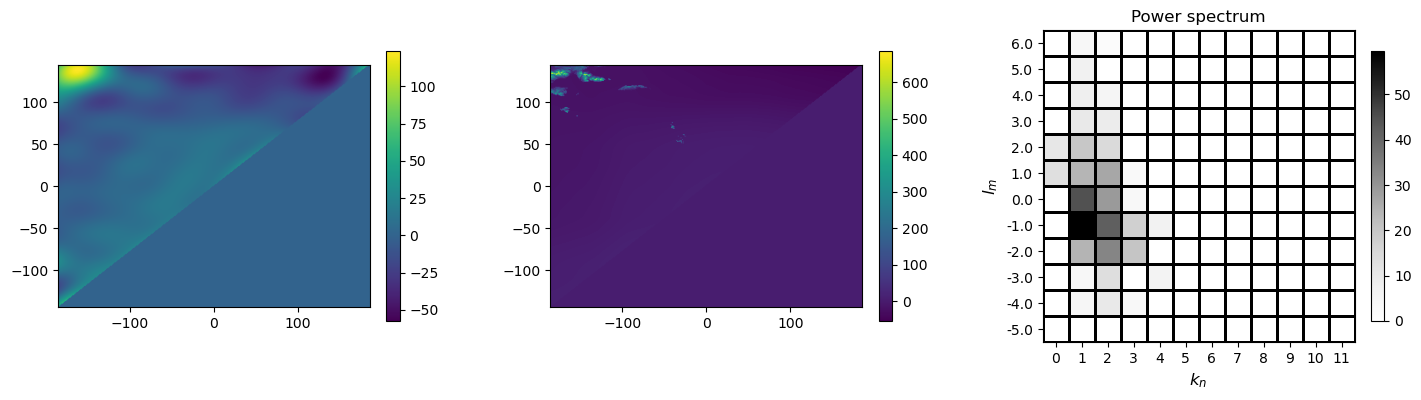

computing idx: 21
56.15262936039683 363.47863006591797
total power = 51.75303251480222
reg max, reg min = 6.463149098165107 0.0
[6.463149098165107, 6.264155957844139, 3.7519655310242426, 3.0902635105556344, 3.045655584969144, 2.9461234105719827, 2.4751986216134285, 2.1109684813778906, 2.0645275835230046, 1.9715790487524072, 1.8095777017992587, 1.5171068661911908, 1.5143724087500297, 1.4012513026761817, 1.1189386536281318, 1.0681442427405454, 1.0216835654632412, 0.9957637555741108, 0.884592082420449, 0.8142523917668522, 0.7887664640358734, 0.7305259693070802, 0.7194379821577331, 0.7145273821398127, 0.6688604329912508, 0.5939556240642495, 0.4645688339465341] 27


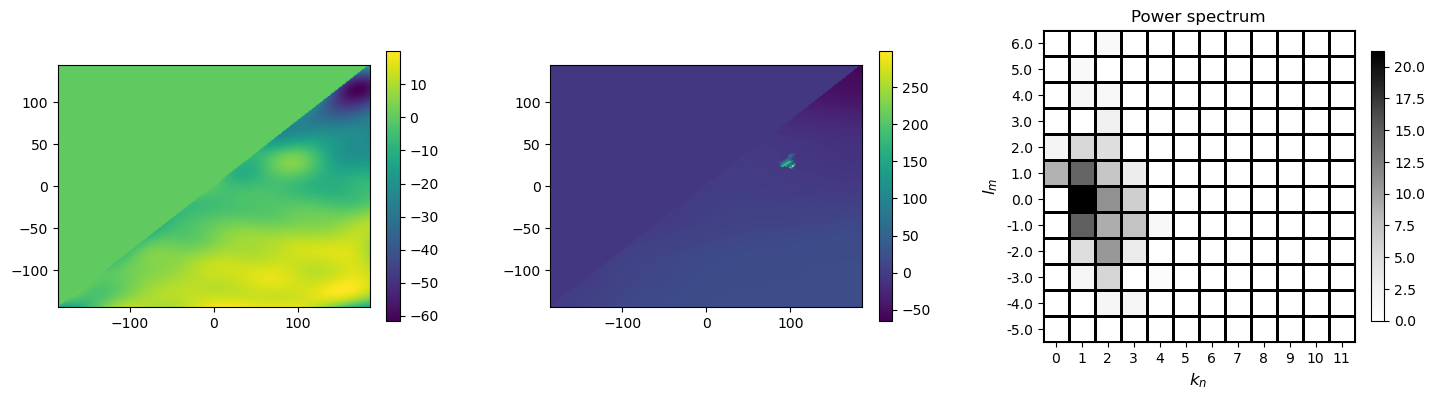

In [54]:
importlib.reload(var)
# Setup the Fourier parameters and object.
nhi = 12
nhj = 12

fobj = fourier.f_trans(nhi,nhj)

# For each triangle...
# for idx in range(len(tri.simplices)):

all_cells = np.zeros(2, dtype='object')

# for cnt, idx in enumerate(range(0,2)):
# for cnt, idx in enumerate(range(2,4)):
# for cnt, idx in enumerate(range(4,6)):
# for cnt, idx in enumerate(range(6,8)):
# for cnt, idx in enumerate(range(8,10)):
# for cnt, idx in enumerate(range(10,12)):
# for cnt, idx in enumerate(range(12,14)):
# for cnt, idx in enumerate(range(14,16)):
# for cnt, idx in enumerate(range(16,18)):
# for cnt, idx in enumerate(range(18,20)):
for cnt, idx in enumerate(range(20,22)):
    # initialise cell object
    cell = var.topo_cell()
    
    print("computing idx:", idx)
    simplex_lat = circ_tri_lat_verts[idx]
    simplex_lon = circ_tri_lon_verts[idx]

    polygon = np.array([list(item) for item in zip(simplex_lon, simplex_lat)])

    init_poly = mask_wrapper(polygon)
    cell.mask = np.array([init_poly(elem) for elem in lat_lon_mgrid]).reshape(topo.lon_grid.shape[0],topo.lon_grid.shape[1]).astype('bool_')
    
    get_lat_lon_segments(tri_lat_verts[idx], tri_lon_verts[idx], cell, topo)
    
    # do fourier...
    fobj.do_full(cell)
    am, data_recons = lin_reg.do(fobj, cell, lmbda = 0.5)
    
    dat_2D = reconstruction.recon_2D(data_recons, cell)
    
    print(dat_2D.max() - dat_2D.min(), cell.topo_m.max() - cell.topo_m.min())
    fobj.get_freq_grid(am)
    freqs = np.abs(fobj.ampls)
    
    fq_cpy = np.copy(freqs)
    total_power = fq_cpy.sum()
    print("total power =", total_power)
    print("reg max, reg min =", fq_cpy.max(), fq_cpy.min())

    indices = []
    max_ampls = []
    for ii in range(30):
        max_idx = np.unravel_index(fq_cpy.argmax(), fq_cpy.shape)
        indices.append(max_idx)
        max_ampls.append(fq_cpy[max_idx])
        max_val = fq_cpy[max_idx]
        fq_cpy[max_idx] = 0.0
        
        if (sum(max_ampls) >= total_power):
            break
        # if sum(max_ampls) >= (total_power / 44000) * 44000:
            # break
        if max_val < 0.01 * total_power:
        # if max_ampls[-1] <= 0.1 * max_ampls[0]:
            break
        
             
    print(max_ampls, len(max_ampls))
    k_idxs = [pair[1] for pair in indices]
    l_idxs = [pair[0] for pair in indices]
    
    fobj.set_kls(k_idxs, l_idxs)
    fobj.do_full(cell)

    am, data_recons = lin_reg.do(fobj, cell, lmbda = 1e-5)

    fobj.get_freq_grid(am)
    dat_2D = reconstruction.recon_2D(data_recons, cell)

    freqs = np.abs(fobj.ampls)
    
    analysis = var.analysis()
    analysis.get_attrs(fobj, freqs)
    analysis.recon = dat_2D
    
    cell.analysis = analysis
    
    topo_tri = cell.topo * cell.mask
    topo_tri -= topo_tri.mean()
    
    all_cells[cnt] = cell
    
    fs = (18,5)
    fig, axs = plt.subplots(1,3, figsize=fs)
    fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
    axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
    axs[1] = fig_obj.phys_panel(axs[1], topo_tri)
    axs[2] = fig_obj.freq_panel(axs[2], freqs)
    plt.show()

3690.9201216070373
10.0 1.0
True
0.0001566945678251141
True
True
0.00032973721535301665 4.418439535459555e-05 0.0001869608053538061


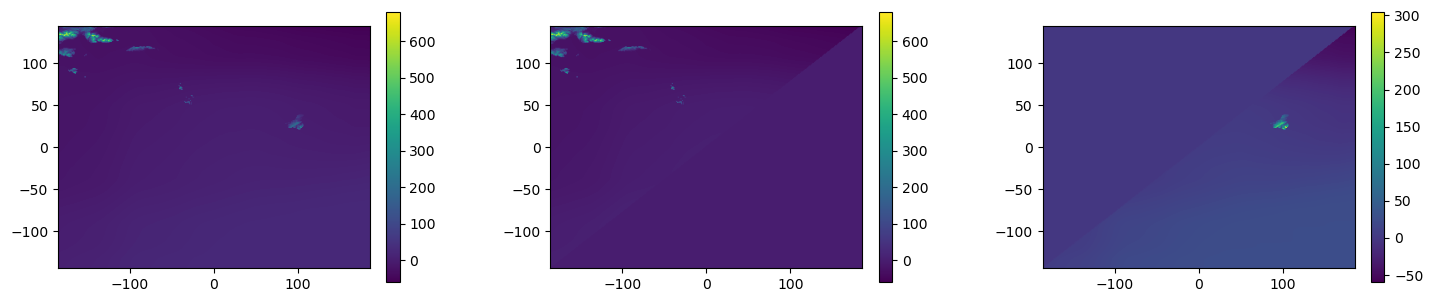

154.12091478506133


In [55]:
importlib.reload(physics)

cell0 = all_cells[0]
cell1 = all_cells[1]

from scipy.ndimage.filters import gaussian_filter
topo_blur = gaussian_filter(cell.topo - cell.topo.mean(), sigma=0)
# topo_blur = cell.topo - cell.topo.mean()

# topo_test = cell0.analysis.recon + cell1.analysis.recon
# ampls = np.fft.fft2(topo_test)

# ampls = np.fft.fft2(cell.topo - cell.topo.mean())
ampls = np.fft.fft2(topo_blur)
ampls = np.abs(ampls) / cell.topo.size

print(ampls.sum())
ampls = ampls.reshape(-1,)[1:]

wlat = np.diff(cell.lat).max()
wlon = np.diff(cell.lon).max()

sz = cell.topo.size
kks = np.fft.fftfreq(cell.topo.shape[1])
lls = np.fft.fftfreq(cell.topo.shape[0])

kkg, llg = np.meshgrid(kks, lls)

analysis = var.analysis()
analysis.wlat = wlat
analysis.wlon = wlon
analysis.ampls = ampls
analysis.kks = kkg.reshape(-1,)[1:] #/ kkg.size
analysis.lls = llg.reshape(-1,)[1:] #/ llg.size

ideal = physics.ideal_pmf(U=10.0, V=1.0)

print(ideal.U, ideal.V)

uw_ref = ideal.compute_uw_pmf(analysis)
print(uw_ref)

uw0 = ideal.compute_uw_pmf(all_cells[0].analysis) #* all_cells[0].topo_m.size
uw1 = ideal.compute_uw_pmf(all_cells[1].analysis) #* all_cells[1].topo_m.size

uw01 = 0.5 * (uw0 + uw1) #/ all_cells[0].topo.size
print(uw0, uw1, uw01)

fs = (18,5)
fig, axs = plt.subplots(1,3, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
# axs[0] = fig_obj.phys_panel(axs[0], cell.topo)
axs[0] = fig_obj.phys_panel(axs[0], topo_blur)
axs[1] = fig_obj.phys_panel(axs[1], cell.topo * cell0.mask)
axs[2] = fig_obj.phys_panel(axs[2], cell.topo * cell1.mask)
# axs[2] = fig_obj.freq_panel(axs[2], np.fft.fftshift(freqs), nhi=cell.topo.shape[1], nhj=cell.topo.shape[0])
plt.show()

print(freqs.sum())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9

In [56]:
print(topo.lat_grid[cell.mask].shape)

(1440, 3720)
(1440, 3720)
(53755,)


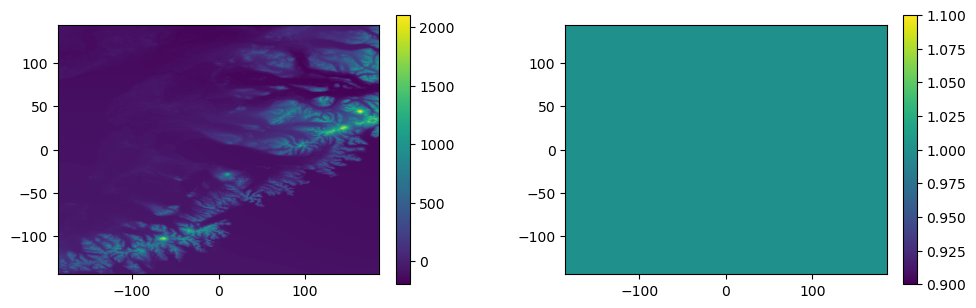

(288, 371)


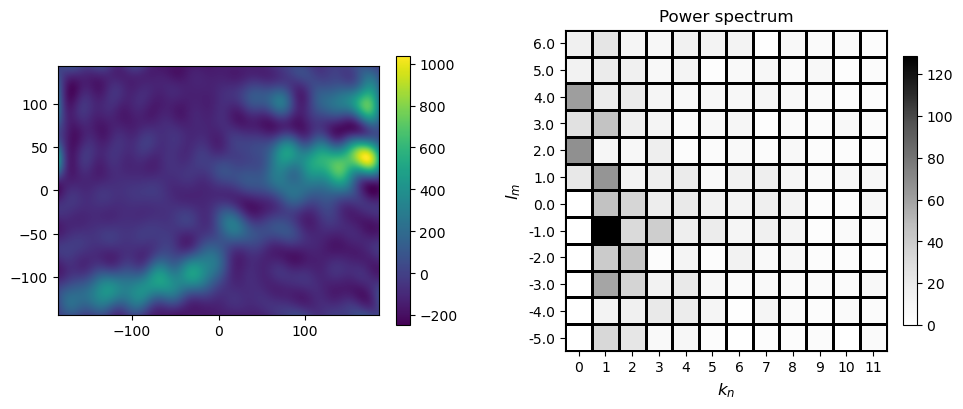

1892.702862112875


In [425]:
nhi = 12
nhj = 12

fobj = fourier.f_trans(nhi,nhj)

cell0 = all_cells[0]

cell0.mask[...] = 1

fs = (12,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], cell0.topo)
axs[1] = fig_obj.phys_panel(axs[1], cell0.mask)
plt.show()

cell0.topo_m = cell0.topo[cell0.mask]
cell0.topo_m -= cell0.topo_m.mean()
cell0.lat_m = cell0.lat_grid[cell0.mask]
cell0.lon_m = cell0.lon_grid[cell0.mask]

fobj.do_full(cell0)
am, data_recons = lin_reg.do(fobj, cell0, lmbda = 0.0)

print(cell.topo.shape)

dat_2D = reconstruction.recon_2D(data_recons, cell0)

fobj.get_freq_grid(am)
freqs = np.abs(fobj.ampls)

fs = (12,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
axs[1] = fig_obj.freq_panel(axs[1], freqs)
plt.show()

print(freqs.sum())

In [233]:
print(fobj.Nj)
print(fobj.I)

print(fobj.Nj)
print(fobj.J)

288
[  0   1   2 ... 368 369 370]
288
[  0   0   0 ... 287 287 287]


In [414]:
fft_ampls = np.fft.fft2(cell0.topo - cell0.topo.mean())
fft_ampls = np.abs(fft_ampls) / cell0.topo.size
fft_freqs = np.copy(fft_ampls)

# sz_fft = fft_ampls.size
# fft_add_ampls = fft_ampls.reshape(-1,)[1:int(sz_fft/2+1)] + fft_ampls.reshape(-1,)[int(sz_fft/2):][::-1]
# fft_add_ampls = np.append(fft_ampls[0], fft_add_ampls)

# print(np.sort(fft_add_ampls)[::-1])

print(fft_ampls.max())
print(freqs.max())

print(fft_ampls.sum())
print(freqs.sum())

ampls_sorted = np.sort(fft_ampls.reshape(-1,))[::-1][:288]
# print(ampls_sorted)
ampls_summed = ampls_sorted[1::2] + ampls_sorted[:-1:2]

print(ampls_summed)

print(np.sort(freqs.reshape(-1,))[::-1])

print(ampls_summed.sum())
print(np.sort(freqs.reshape(-1,))[::-1].sum())


# print(np.sort(fft_ampls.reshape(-1,))[::-1].sum())

# print(np.sort(freqs.reshape(-1,))[::-1].sum())


64.44394201729227
128.88788403458332
19802.992962466855
1892.702862112875
[128.88788403  67.22735009  64.67067342  60.98149094  58.39509556
  45.53333983  44.83492982  42.88200549  40.52325952  38.30845315
  35.0109608   33.93057632  33.06837964  31.36069848  26.90758768
  24.06830062  23.88698011  23.54945683  23.26477256  21.83140863
  21.34499449  21.32237034  21.27301236  21.05272651  20.02560802
  19.82663464  19.65886424  19.36119018  19.25954281  18.7001501
  18.6283869   18.60962986  17.71118799  17.63378111  17.58151692
  17.49376354  17.26066126  16.90117119  16.62037837  16.42932154
  16.35975987  16.30180678  16.28355406  15.92722806  15.74854487
  15.41467953  15.37199312  14.74263982  14.61593336  14.55196501
  14.53341146  14.45556723  14.36597993  14.07290851  13.97230828
  13.70707393  13.61183238  13.55461752  13.45245368  13.43623194
  13.43429184  13.4188217   13.40710586  13.28379338  13.17039964
  12.6826663   12.67339671  12.63491429  12.27073872  12.26534082
  1

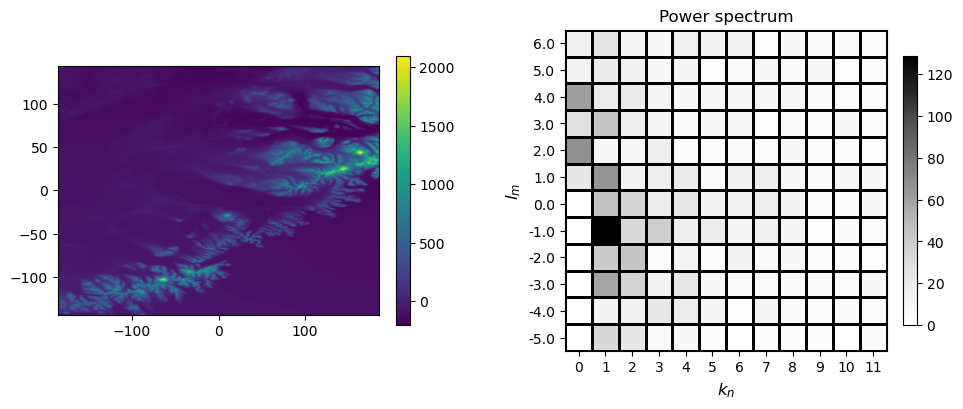

In [409]:
fft_ampls = np.fft.fft2(cell0.topo - cell0.topo.mean())

physical = np.fft.ifft2(fft_ampls).real

fs = (12,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], physical)
axs[1] = fig_obj.freq_panel(axs[1], freqs)
plt.show()



AttributeError: 'topo_cell' object has no attribute 'I'